### Importing relevant packages

In [1]:
import pickle
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import pomegranate
from pomegranate import *

### Picking n samples

In [2]:
n=1000

### Loading lgd and ead demo data

In [3]:
df = pd.read_csv("demo.csv")
df=df[:n]

### Loading xgboost data

In [4]:
df_xg = pd.read_csv("xg_data.csv")
df_xg=df_xg[:n]
df_xg.head()

,grade,home_ownership,verification_status,purpose,initial_list_status,term,emp_length_int,mths_since_issue_d,int_rate,annual_inc,mths_since_last_delinq
0,2,2,2,2,0,0,0,5,1,7,0
1,0,0,0,1,0,0,3,5,2,9,4
2,1,2,2,5,0,0,2,6,3,6,3
3,3,2,2,8,0,0,0,3,1,4,4
4,3,2,1,1,0,1,3,6,3,7,1


### Loading pd demo data

In [5]:
df_bayes = pd.read_csv('bayes_demo.csv')
df_bayes=df_bayes[:n]

In [6]:
df_bayes.drop(['verification_status','initial_list_status','good_bad','mths_since_issue_d'],axis=1,inplace=True)
df_bayes['emp_length_int']=df_bayes['emp_length_int'].astype(np.str)



In [7]:
df_bayes.head()

,grade,home_ownership,purpose,term,emp_length_int,int_rate,annual_inc,mths_since_last_delinq
0,B,RENT,credit_card,3 years,7,fair,30k,unknown
1,C,RENT,car,5 years,1,modrate,30k,unknown
2,C,RENT,small_business,3 years,7,high,20k,unknown
3,C,RENT,other,3 years,7,modrate,50k,less than 56
4,B,RENT,other,5 years,1,modrate,80k,less than 56


In [8]:
w=[]
for index,row in df_bayes.iterrows():
    w.append(dict(zip(df_bayes.columns.values,row)))

### Creating empty df

In [9]:
df_new= pd.DataFrame()

### Calling api for lgd

In [10]:
base_site=" http://127.0.0.1:5000/predict_lgd"

In [11]:
r= requests.post(url=base_site,json=df.values.tolist())
df_new['lgd']= np.ones(shape=(n,))-np.array(r.json())
df_new['lgd'].describe()

count    1000.000000
mean        0.919414
std         0.012218
min         0.867052
25%         0.911343
50%         0.920904
75%         0.928057
max         0.949228
Name: lgd, dtype: float64

### Calling api for ead

In [12]:
base_site=" http://127.0.0.1:5000/predict_ead"

In [13]:
r= requests.post(url=base_site,json=df.values.tolist())
df_new['ead']= r.json()*df['funded_amnt']
df_new['ead'].describe()

count     1000.000000
mean      7998.515782
std       4920.988381
min        661.621792
25%       4262.971056
50%       6733.176608
75%      10557.890125
max      28963.392621
Name: ead, dtype: float64

### Calling api for pd_xg

In [84]:
base_site= "http://127.0.0.1:5000/predict_xg"

In [106]:
r= requests.post(url=base_site,json=df_xg.values.tolist())
df_new['pd']= r.json()
df_new['pd'].describe()

count    1000.000000
mean        0.107299
std         0.100135
min         0.000125
25%         0.037486
50%         0.085225
75%         0.147251
max         0.942908
Name: pd, dtype: float64

### Evaluating expected loss

In [16]:
df_new.head()

,lgd,ead,pd
0,0.913729,2949.608449,0.284819
1,0.915482,1944.433378,0.069817
2,0.919484,1579.934302,0.169555
3,0.904924,6606.559612,0.076054
4,0.911453,2124.631667,0.279079


In [17]:
df_new['EL']= df_new['lgd']*df_new['ead']*df_new['pd']

In [18]:
df_new.head()

,lgd,ead,pd,EL
0,0.913729,2949.608449,0.284819,767.626696
1,0.915482,1944.433378,0.069817,124.281297
2,0.919484,1579.934302,0.169555,246.316895
3,0.904924,6606.559612,0.076054,454.685233
4,0.911453,2124.631667,0.279079,540.437857


In [19]:
df_new['EL'].sum()

777638.2854405127

### Loss percentage

In [20]:
df_new['funded_amount']= df['funded_amnt']

In [21]:
df_new['EL'].sum()*100/df_new['funded_amount'].sum()

6.374293300112403

### Changing cut-off point VS loss percentage 

In [22]:
def get_loss_percent(data,cut_off):
    df1=data.copy()
    df1['pd']= np.where(df1['pd']>cut_off,0,df1['pd'])
    df1['EL'] = df1['lgd']*df1['ead']*df1['pd']
    return df1['EL'].sum()*100/df1['funded_amount'].sum()

In [23]:
get_loss_percent(df_new,0.1)

1.589997708367812

In [24]:
get_loss_percent(df_new,0.15)

2.9414820160577637

In [25]:
get_loss_percent(df_new,0.2)

4.205003031893023

In [26]:
get_loss_percent(df_new,0.3)

5.538648645618552

### Typically this value ranges from 2 to 10% so we are on safe side

In [27]:
import matplotlib.pyplot as plt

In [28]:
x= [0.05,0.1,0.15,0.2,0.25,0.3]
y= [get_loss_percent(df_new,i) for i in x]

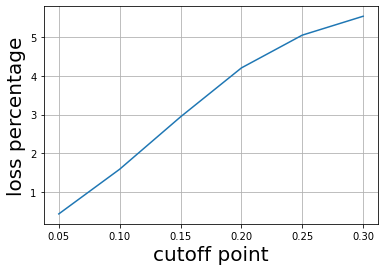

In [29]:
plt.plot(x,y)
plt.grid()
plt.xlabel('cutoff point',fontsize=20)
plt.ylabel('loss percentage',fontsize=20)
plt.show()

### Congratulations! great work

### Bayesian Network / Factor Graphs

<h1 style="color:blue"> What happens during training </h1>

<img src="img2.jpg" width="570" height="400">

<h1 style="color:blue"> What happens during inference </h1>

<img src="img.png" width="570" height="400">

### Building the graph

In [30]:
import networkx as nx
G = nx.DiGraph()

In [31]:
A= {
    'income':['home_ownership','term'],
    'emp_length':['home_ownership','delinq'],
    'purpose':['term','int_rate','delinq'],
    'home_ownership':['grade'],
    'term':['int_rate'],
    'int_rate':['grade'],
    'grade':['loan_status'],
     'delinq':['loan_status'],

    
}
G=nx.DiGraph(A)


### Visualization

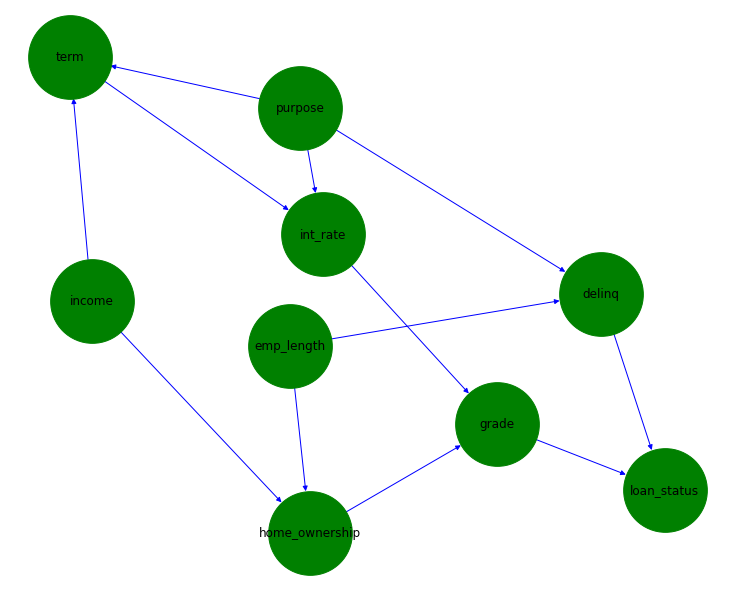

In [32]:
plt.figure(figsize=(10,8))
pos = nx.spring_layout(G,seed=6)
nx.draw(G,node_size=7000,node_color='g',pos=pos,with_labels=True,edge_color='b')


### Loading our data

In [33]:
df= pd.read_csv('bayes_demo.csv')

### Automating the pipeline

#### Getting conditional probability distribution

In [34]:
def get_conditional_prob_distribution(df,child,parents):
    
    parent_list = [df[i] for i in parents]
    
    df1= pd.crosstab(df[child[0]],parent_list).apply(lambda r: r/r.sum(), axis=0)
    
    c=pd.crosstab(df[child[0]],parent_list).apply(lambda r: r/r.sum(), axis=0).columns.values

    r=pd.crosstab(df[child[0]],parent_list).apply(lambda r: r/r.sum(), axis=0).index.values
    
    A=[]
    for i in range(df1.shape[0]):
        for j in range(df1.shape[1]):
            w=[]

            
            if type(c[j])==str:
                w.append(c[j])
            else:
                w= [u  for u in (c[j])]
            w.append(r[i])
            w.append(df1.iloc[i,j])
            A.append(w)
            
            
        
    return A


In [35]:
get_conditional_prob_distribution(df,['term'],['annual_inc','purpose'])

[['+140k', 'car', ' 3 years', 0.7620967741935484],
 ['+140k', 'credit_card', ' 3 years', 0.7482856664994146],
 ['+140k', 'debt_consolidation', ' 3 years', 0.6661630382528673],
 ['+140k', 'educational', ' 3 years', 1.0],
 ['+140k', 'home_improvement', ' 3 years', 0.6591136287904032],
 ['+140k', 'house', ' 3 years', 0.6548223350253807],
 ['+140k', 'major_purchase', ' 3 years', 0.719640179910045],
 ['+140k', 'medical', ' 3 years', 0.7674418604651163],
 ['+140k', 'moving', ' 3 years', 0.7633136094674556],
 ['+140k', 'other', ' 3 years', 0.7122247532270312],
 ['+140k', 'renewable_energy', ' 3 years', 0.76],
 ['+140k', 'small_business', ' 3 years', 0.720677146311971],
 ['+140k', 'vacation', ' 3 years', 0.875],
 ['+140k', 'wedding', ' 3 years', 0.7387387387387387],
 ['100k', 'car', ' 3 years', 0.6616541353383458],
 ['100k', 'credit_card', ' 3 years', 0.7166936790923825],
 ['100k', 'debt_consolidation', ' 3 years', 0.631484794275492],
 ['100k', 'educational', ' 3 years', 1.0],
 ['100k', 'home_

#### Getting marginal probability distribution

In [36]:
def get_marginal_prob_distribution(df,variable):
    
    df1= df[variable].value_counts(normalize=True)
    
    d=dict(zip(df1.index,df1.values))


    return d

In [37]:
get_marginal_prob_distribution(df,'annual_inc')

{'50k': 0.1472067494614335,
 '60k': 0.14266004651841424,
 '70k': 0.11617373168659291,
 '40k': 0.11570168135744509,
 '80k': 0.1005338460085999,
 '90k': 0.07513968398376147,
 '120k': 0.0708161321054303,
 '100k': 0.06071210937835263,
 '30k': 0.06008986121720323,
 '+140k': 0.059055641859706645,
 '140k': 0.03671478719112889,
 '20k': 0.015195729231931202}

### Setting nodes and corresponding cpds

In [38]:
annual_inc = DiscreteDistribution(get_marginal_prob_distribution(df,'annual_inc'))

emp_length_int = DiscreteDistribution(get_marginal_prob_distribution(df,'emp_length_int'))

purpose = DiscreteDistribution(get_marginal_prob_distribution(df,'purpose'))


In [39]:
home_ownership= ConditionalProbabilityTable(
    get_conditional_prob_distribution(df,['home_ownership'],['annual_inc','emp_length_int']), 
    [annual_inc, emp_length_int]

) 

In [40]:
term= ConditionalProbabilityTable(
    get_conditional_prob_distribution(df,['term'],['annual_inc','purpose']), 
    [annual_inc, purpose]

) 

In [41]:
int_rate= ConditionalProbabilityTable(
    get_conditional_prob_distribution(df,['int_rate'],['term','purpose']), 
    [term,purpose]

) 

In [42]:
grade= ConditionalProbabilityTable(
    get_conditional_prob_distribution(df,['grade'],['home_ownership','emp_length_int','int_rate']), 
    [home_ownership,emp_length_int,int_rate]

) 

In [43]:
mths_since_last_delinq= ConditionalProbabilityTable(
    get_conditional_prob_distribution(df,['mths_since_last_delinq'],['purpose','emp_length_int']), 
    [purpose,emp_length_int]

) 

In [44]:
creditworthiness= ConditionalProbabilityTable(
    get_conditional_prob_distribution(df,['good_bad'],['grade','mths_since_last_delinq']), 
    [grade,mths_since_last_delinq]

) 

### Setting Nodes

In [45]:
s1 = Node(annual_inc, name="annual_inc")
s2 = Node(emp_length_int, name="emp_length_int")
s3 = Node(purpose, name="purpose")
s4 = Node(home_ownership, name="home_ownership")
s5 = Node(term, name="term")
s6 = Node(grade, name="grade")
s7 = Node(int_rate, name="int_rate")
s8 = Node(mths_since_last_delinq, name="mths_since_last_delinq")
s9 = Node(creditworthiness, name="creditworthiness")

### Constructing connections

In [46]:
model = BayesianNetwork("Credit Worthiness")

model.add_nodes(s1, s2, s3, s4, s5, s6, s7, s8,s9)
model.add_edge(s1, s4)
model.add_edge(s1, s5)
model.add_edge(s2, s4)
model.add_edge(s2, s6)
model.add_edge(s2, s8)
model.add_edge(s3, s5)
model.add_edge(s3, s7)
model.add_edge(s3, s8)
model.add_edge(s4, s6)
model.add_edge(s5, s7)
model.add_edge(s6, s9)
model.add_edge(s7, s6)
model.add_edge(s8, s9)

model.bake()

## Now let's get some insights 

### Now we will try to answer some arbitrary questions that are crucial for business decisions

['annual_inc',
 'emp_length_int',
 'purpose',
 'home_ownership',
 'term',
 'grade',
 'int_rate',
 'mths_since_last_delinq',
 'creditworthiness']

In [77]:
base_site="http://127.0.0.1:5000/make_inference"

### What is the percentage of those who got accepted for a loan when their purpose was housing?

In [48]:
r= requests.post(url=base_site,json=[[None,None,'house',None,None,None,None,None,'good']])
r.json()

0.004862118390222552

### What is the percentage of those who got accepted for a loan when their purpose was credit card (shopping)?

In [49]:
r= requests.post(url=base_site,json=[[None,None,'credit_card',None,None,None,None,None,'good']])
r.json()

0.22333559345309104

### What is the percentage of those who were accepted for a loan when their income was 30k?

In [50]:
r= requests.post(url=base_site,json=[['30k',None,None,None,None,None,None,None,'good']])
r.json()

0.060089861217203215

### What is the percentage of those who were accepted for a loan when their income was 80k?

In [51]:
r= requests.post(url=base_site,json=[['80k',None,None,None,None,None,None,None,'good']])
r.json()

0.10053384600859987

### What is the percentage of those who own a house and have an income of 140k?

In [78]:
r= requests.post(url=base_site,json=[['+140k',None,None,'OWN',None,None,None,None,None]])
r.json()

0.05905564185970664

### Calling api for pd_bayes

In [107]:
base_site="http://127.0.0.1:5000/predict_pd"

In [108]:
r= requests.post(url=base_site,json=w)
df_new['pd']= [i["bad"] for i in r.json()]
df_new['pd'].describe()

count    1000.000000
mean        0.104592
std         0.052536
min         0.033514
25%         0.069963
50%         0.084857
75%         0.124382
max         0.290690
Name: pd, dtype: float64